<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/gans/WGAN_DIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Wasserstein Divergence for GANs](https://arxiv.org/pdf/1712.01026.pdf)

In [40]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
import numpy as np
import math
from torch import autograd
from torchsummary import summary

In [41]:
n_epochs = 200
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
img_size = 28
channels = 1
n_critic = 5
clip_value = 0.01
batch_size = 64
img_shape = (channels,img_size,img_size)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
display_step = 5000

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        def block(in_feats,out_feats,normalize = True):
            layers = [nn.Linear(in_feats,out_feats)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feats,0.8))
            layers.append(nn.LeakyReLU(0.2,inplace = True))
            return layers
        self.model = nn.Sequential(
            *block(latent_dim,128,normalize = False),
            *block(128,256),
            *block(256,512),
            *block(512,1024),
            nn.Linear(1024,int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self,z):
        img = self.model(z)
        img = img.view(img.size(0),*img_shape)
        return img

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)),512),
            nn.LeakyReLU(0.8,inplace = True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.8,inplace = True),
            nn.Linear(256,1),
        )
    def forward(self,img):
        img_flatten = img.view(img.size(0),-1)
        out = self.model(img_flatten)
        return out

In [44]:
k = 2
p = 6
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(),lr = lr, betas= (b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr , betas = (b1,b2))


In [45]:
dataloader = DataLoader(
    datasets.MNIST(
        './root',
        download = True,
        train = True,
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    ),
    batch_size = batch_size,
    shuffle = True
)

In [46]:
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()





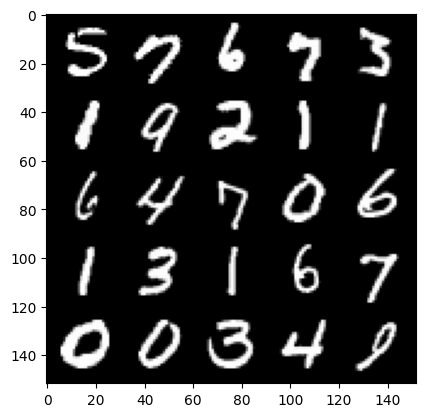

In [47]:
images,labels = next(iter(dataloader))
show_tensor_images(images)

In [48]:
from tqdm import tqdm
def calculate_gradient_penalty(real_data, fake_data, real_outputs, fake_outputs, k=2, p=6):
    real_grad_outputs = torch.full((real_data.size(0),1), 1, dtype=torch.float32, requires_grad=False, device=device)
    fake_grad_outputs = torch.full((fake_data.size(0),1), 1, dtype=torch.float32, requires_grad=False, device=device)

    real_gradient = torch.autograd.grad(
        outputs=real_outputs,
        inputs=real_data,
        grad_outputs=real_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    fake_gradient = torch.autograd.grad(
        outputs=fake_outputs,
        inputs=fake_data,
        grad_outputs=fake_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    real_gradient_norm = real_gradient.view(real_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)
    fake_gradient_norm = fake_gradient.view(fake_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)

    gradient_penalty = torch.mean(real_gradient_norm + fake_gradient_norm) * k / 2
    return gradient_penalty

 33%|███▎      | 310/938 [00:06<00:13, 46.43it/s]

Epoch 5, step 5000: Generator loss: -0.71563406053111, discriminator loss: 11.065681408131114
----------------fake images-------------


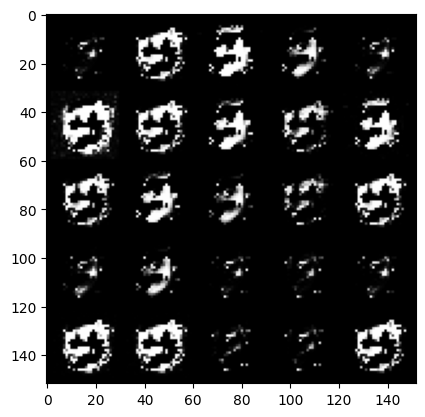

----------------real images-------------


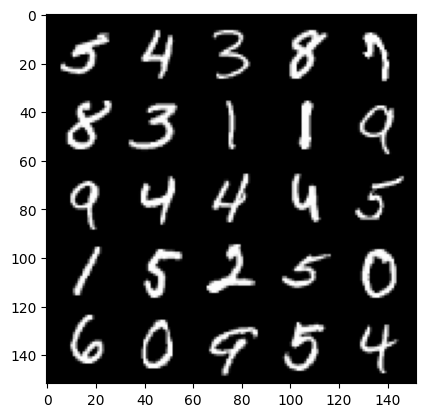

 66%|██████▌   | 619/938 [00:14<00:09, 33.82it/s]

Epoch 10, step 10000: Generator loss: -1.8645519445419354, discriminator loss: -1.4253764272533331
----------------fake images-------------


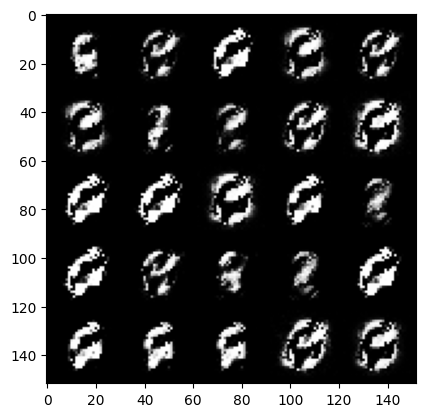

----------------real images-------------


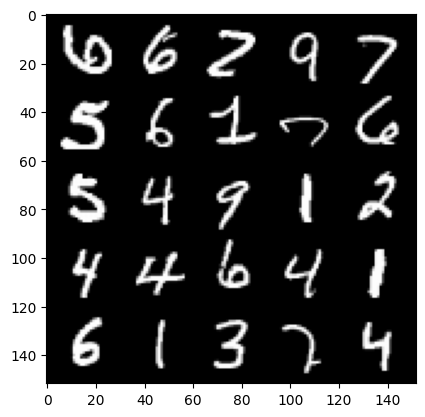

 99%|█████████▉| 927/938 [00:21<00:00, 46.46it/s]

Epoch 15, step 15000: Generator loss: -1.552100576829909, discriminator loss: -0.9648242319762719
----------------fake images-------------


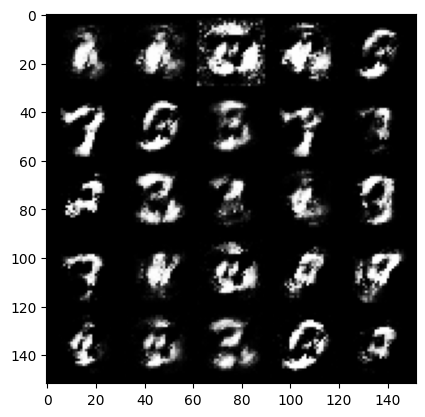

----------------real images-------------


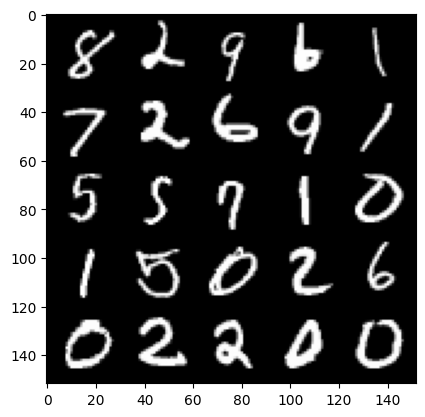

 32%|███▏      | 302/938 [00:06<00:13, 46.40it/s]

Epoch 21, step 20000: Generator loss: -1.3815983745098117, discriminator loss: -1.2117179418385051
----------------fake images-------------


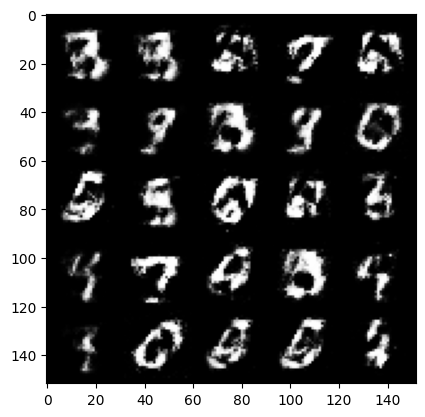

----------------real images-------------


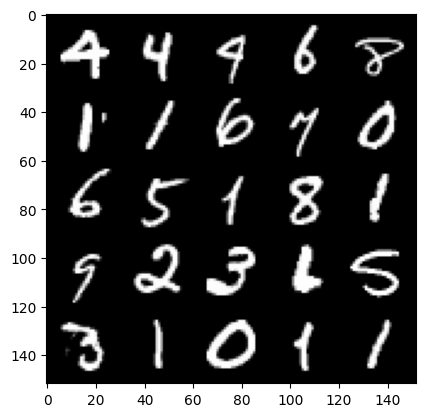

 65%|██████▌   | 611/938 [00:14<00:09, 33.81it/s]

Epoch 26, step 25000: Generator loss: -1.0917424327373515, discriminator loss: -0.9910443082481625
----------------fake images-------------


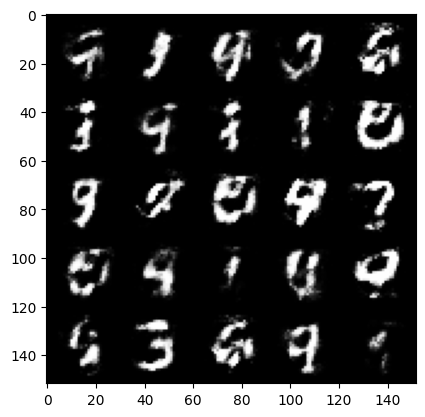

----------------real images-------------


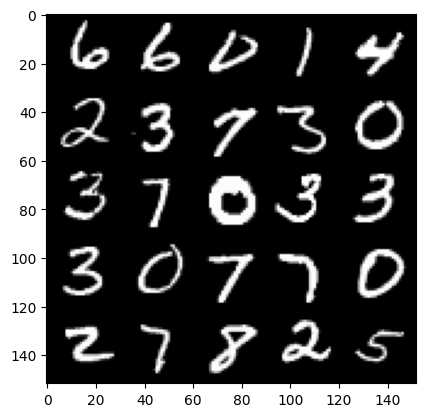

 98%|█████████▊| 922/938 [00:21<00:00, 45.91it/s]

Epoch 31, step 30000: Generator loss: -1.155607550334929, discriminator loss: -0.8643974933147436
----------------fake images-------------


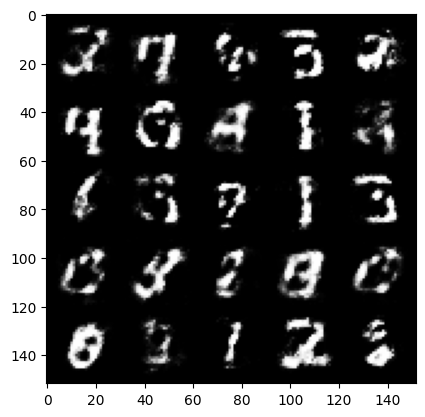

----------------real images-------------


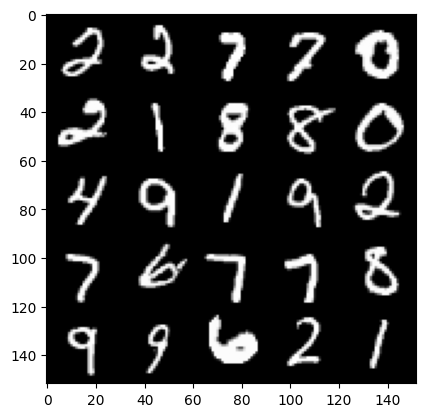

 31%|███       | 290/938 [00:06<00:14, 43.56it/s]

Epoch 37, step 35000: Generator loss: -1.0243007939577111, discriminator loss: -0.8040693914055836
----------------fake images-------------


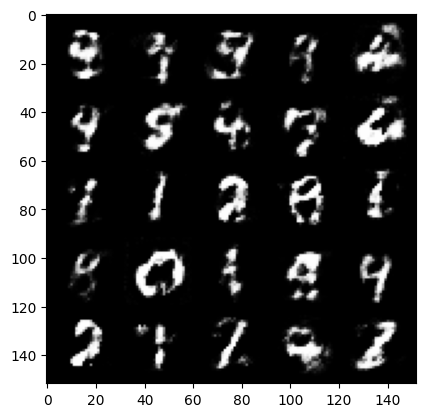

----------------real images-------------


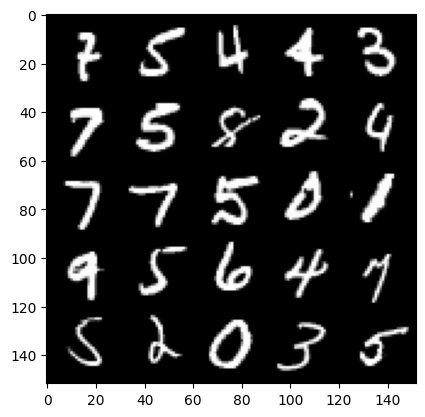

 64%|██████▍   | 604/938 [00:14<00:07, 46.60it/s]

Epoch 42, step 40000: Generator loss: -0.7735163941323758, discriminator loss: -0.7480126316487796
----------------fake images-------------


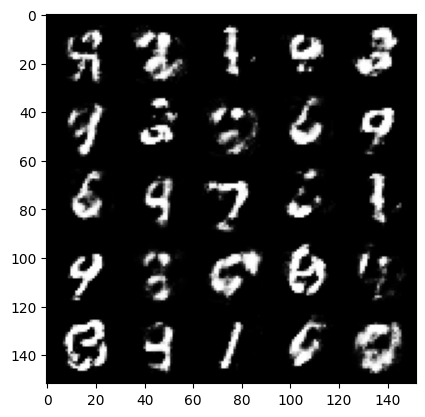

----------------real images-------------


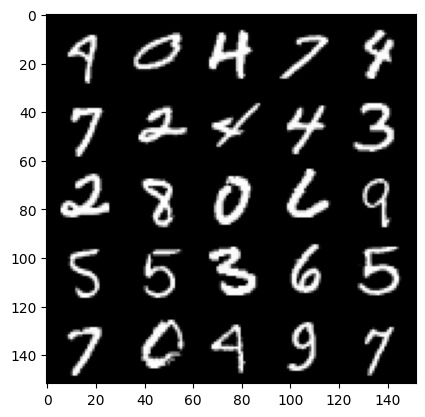

 97%|█████████▋| 910/938 [00:20<00:00, 45.40it/s]

Epoch 47, step 45000: Generator loss: -0.6424195842832324, discriminator loss: -0.6997007811218466
----------------fake images-------------


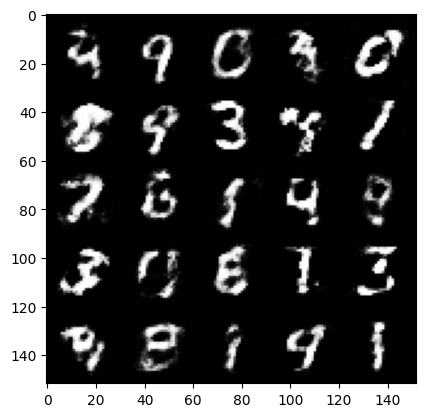

----------------real images-------------


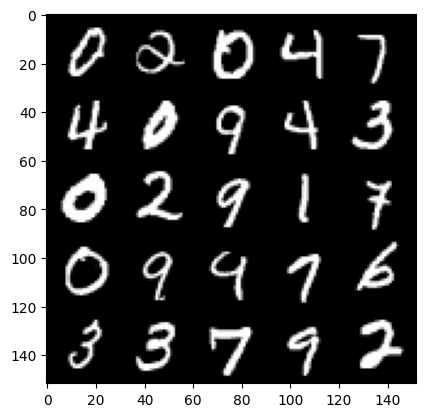

 30%|███       | 285/938 [00:07<00:14, 45.04it/s]

Epoch 53, step 50000: Generator loss: -0.5502146121159199, discriminator loss: -0.6404487109974035
----------------fake images-------------


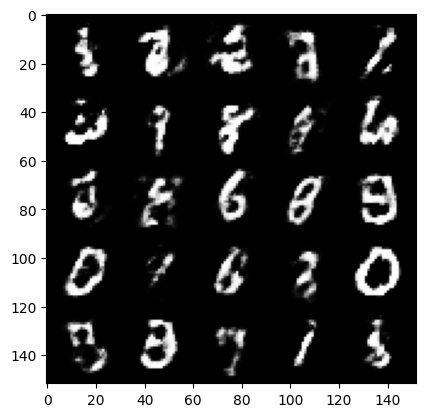

----------------real images-------------


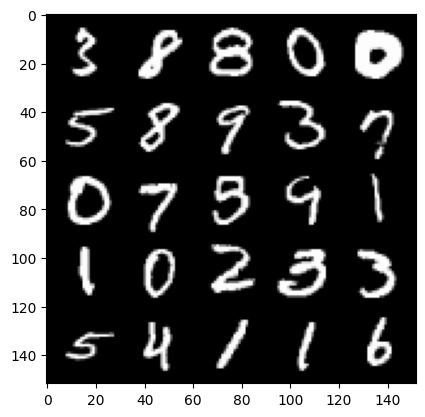

 63%|██████▎   | 595/938 [00:14<00:07, 45.17it/s]

Epoch 58, step 55000: Generator loss: -0.44811988388039187, discriminator loss: -0.5719419974669812
----------------fake images-------------


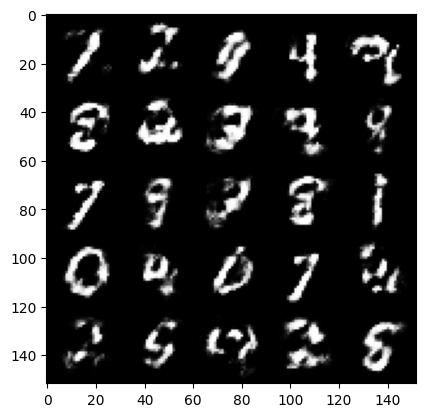

----------------real images-------------


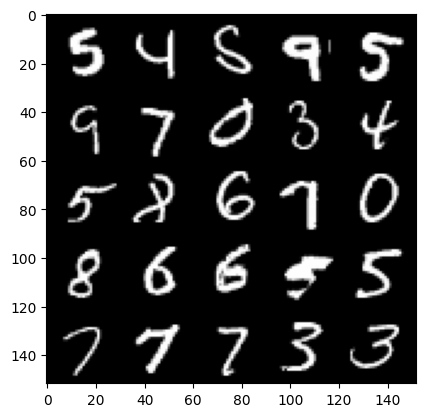

 96%|█████████▋| 905/938 [00:21<00:00, 42.52it/s]

Epoch 63, step 60000: Generator loss: -0.4260412859387692, discriminator loss: -0.5598295349091279
----------------fake images-------------


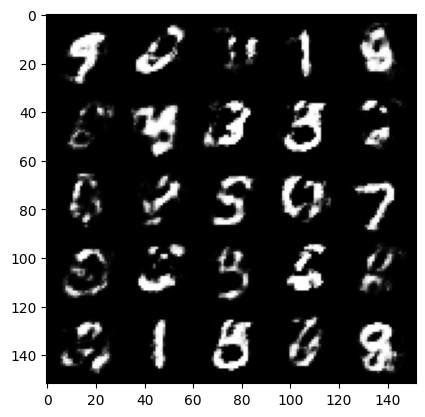

----------------real images-------------


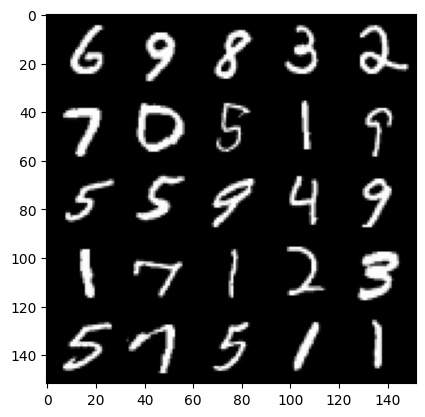

 29%|██▉       | 274/938 [00:06<00:14, 44.57it/s]

Epoch 69, step 65000: Generator loss: -0.40814102210253445, discriminator loss: -0.5141651200354107
----------------fake images-------------


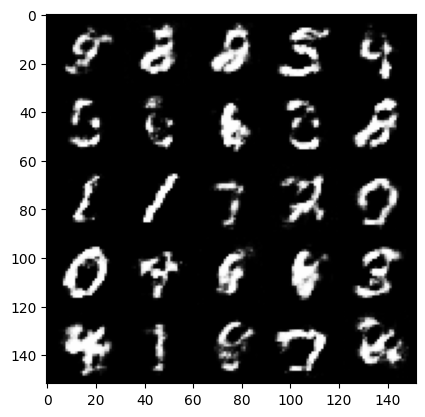

----------------real images-------------


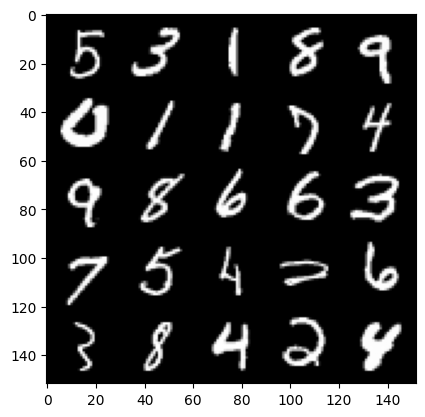

 62%|██████▏   | 586/938 [00:14<00:08, 42.50it/s]

Epoch 74, step 70000: Generator loss: -0.36530639405511345, discriminator loss: -0.4748878445342192
----------------fake images-------------


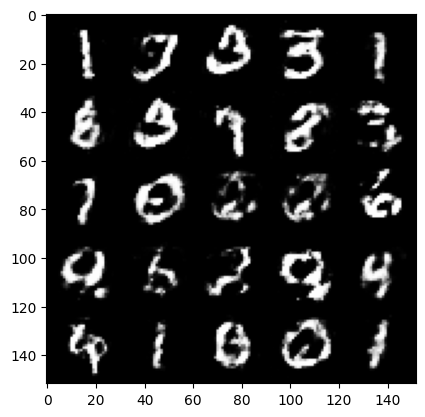

----------------real images-------------


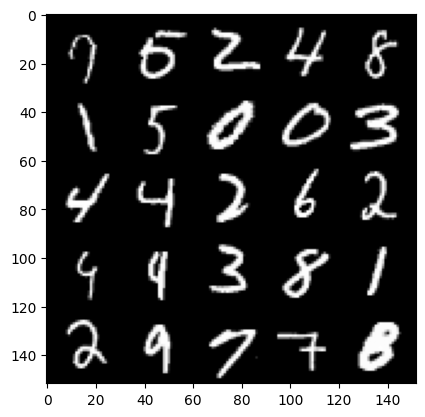

 95%|█████████▌| 894/938 [00:23<00:01, 42.49it/s]

Epoch 79, step 75000: Generator loss: -0.2984586376290769, discriminator loss: -0.45413759638369167
----------------fake images-------------


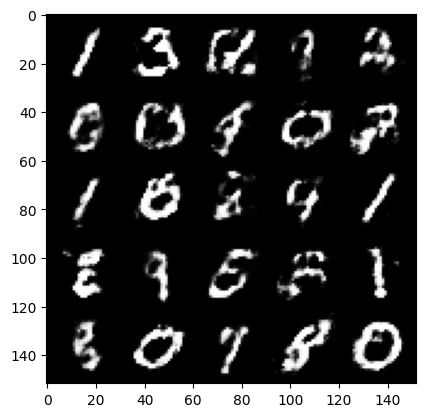

----------------real images-------------


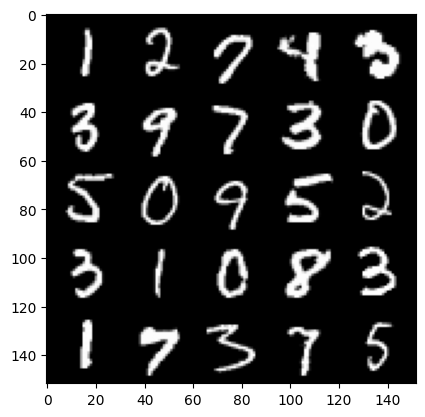

 28%|██▊       | 266/938 [00:07<00:17, 37.36it/s]

Epoch 85, step 80000: Generator loss: -0.27188363411612804, discriminator loss: -0.4366001260131605
----------------fake images-------------


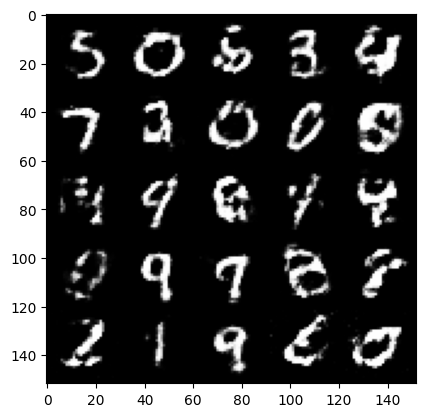

----------------real images-------------


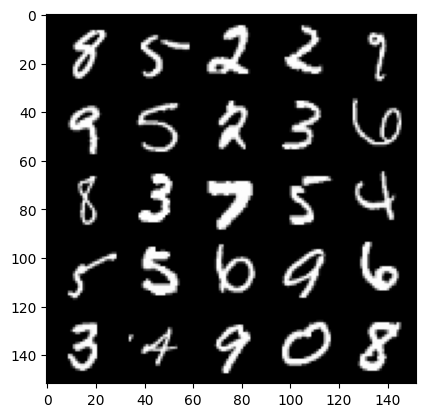

 62%|██████▏   | 577/938 [00:15<00:11, 30.55it/s]

Epoch 90, step 85000: Generator loss: -0.20830082057788982, discriminator loss: -0.4198263129897405
----------------fake images-------------


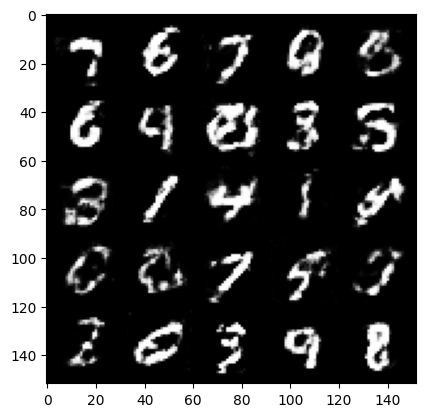

----------------real images-------------


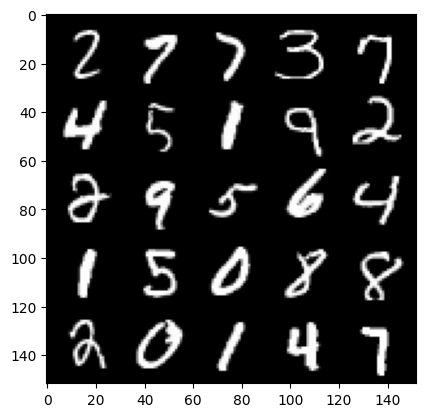

 95%|█████████▍| 889/938 [00:23<00:01, 29.91it/s]

Epoch 95, step 90000: Generator loss: -0.1489447989914562, discriminator loss: -0.40775589692890624
----------------fake images-------------


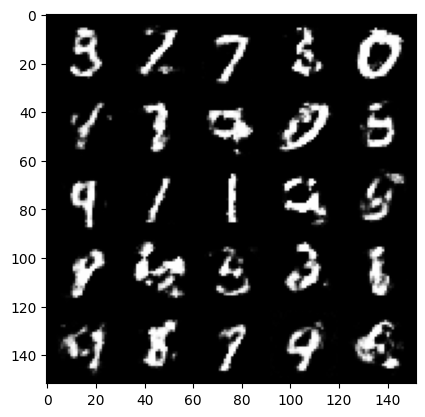

----------------real images-------------


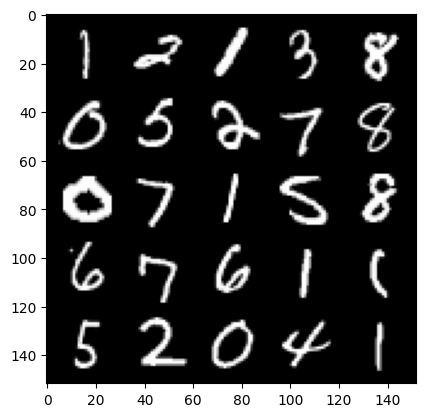

 28%|██▊       | 259/938 [00:07<00:20, 33.28it/s]

Epoch 101, step 95000: Generator loss: -0.12422158946972348, discriminator loss: -0.3860090831272301
----------------fake images-------------


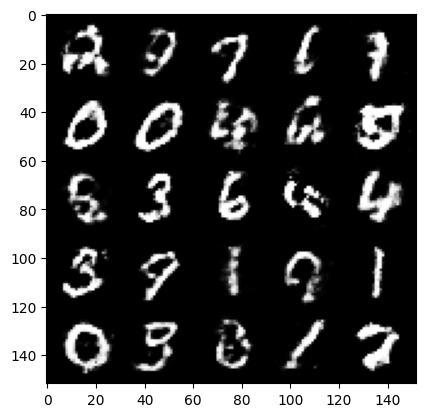

----------------real images-------------


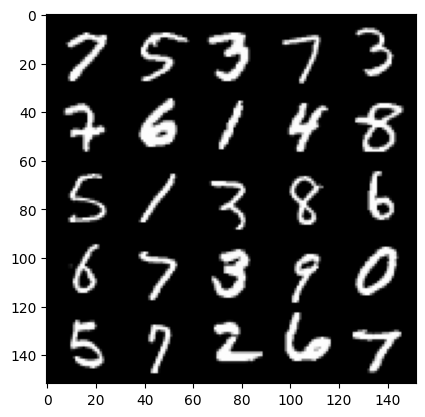

 61%|██████    | 571/938 [00:14<00:08, 42.02it/s]

Epoch 106, step 100000: Generator loss: -0.0523388570964336, discriminator loss: -0.3734985489569607
----------------fake images-------------


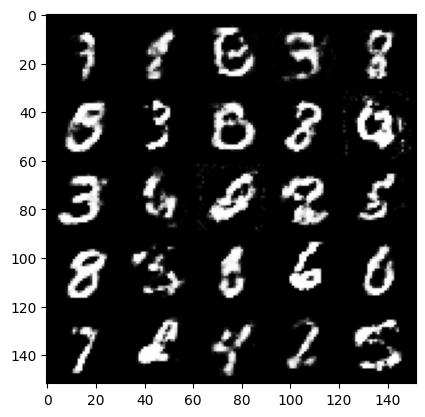

----------------real images-------------


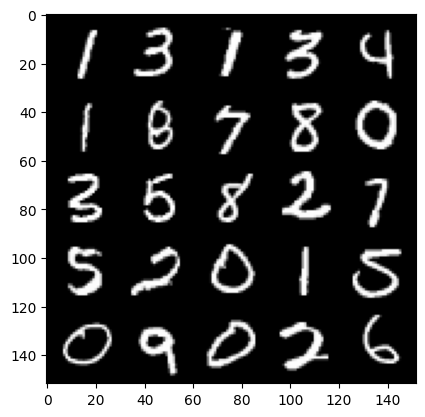

 94%|█████████▎| 879/938 [00:23<00:01, 40.27it/s]

Epoch 111, step 105000: Generator loss: -0.04149411457478997, discriminator loss: -0.3662094279341407
----------------fake images-------------


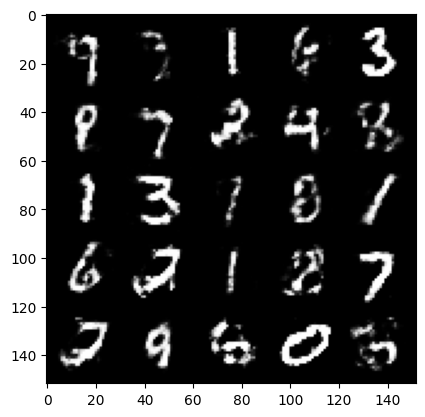

----------------real images-------------


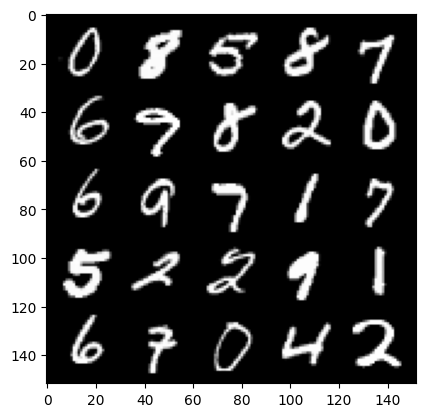

 27%|██▋       | 254/938 [00:06<00:15, 44.47it/s]

Epoch 117, step 110000: Generator loss: -0.012182364553213101, discriminator loss: -0.3570463785134254
----------------fake images-------------


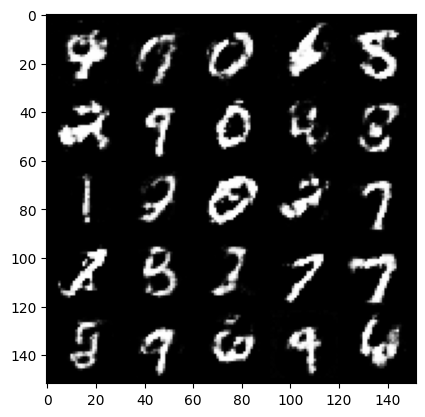

----------------real images-------------


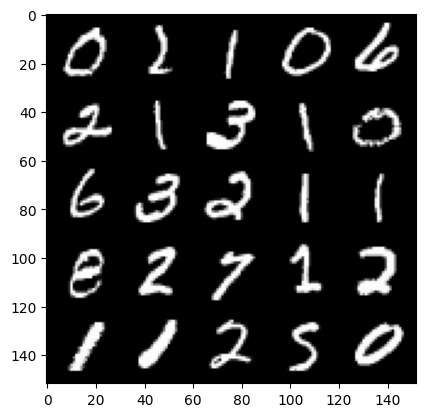

 60%|█████▉    | 560/938 [00:15<00:09, 40.26it/s]

Epoch 122, step 115000: Generator loss: -0.04047339051254094, discriminator loss: -0.34189000495374217
----------------fake images-------------


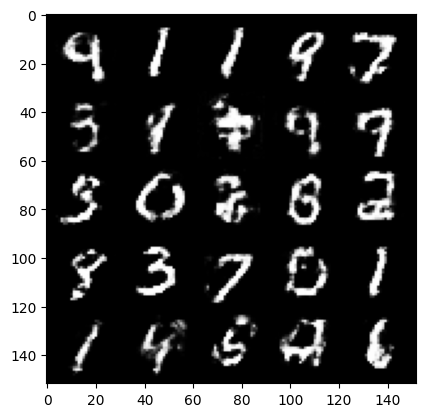

----------------real images-------------


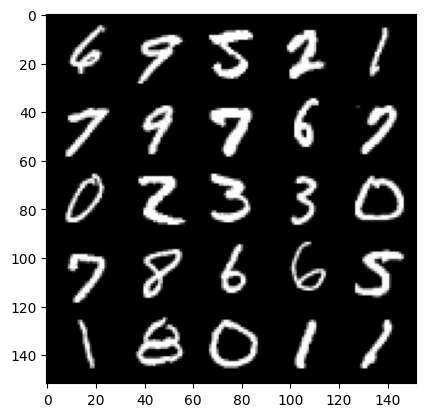

 93%|█████████▎| 874/938 [00:24<00:01, 35.20it/s]

Epoch 127, step 120000: Generator loss: -0.013321935638412824, discriminator loss: -0.3359913458473979
----------------fake images-------------


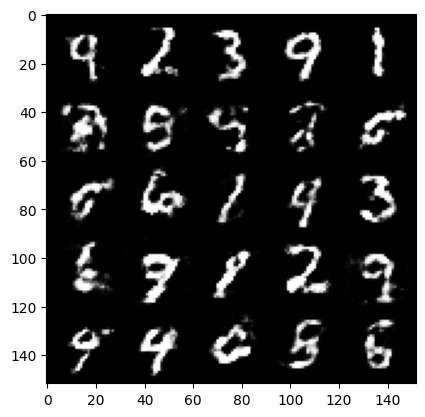

----------------real images-------------


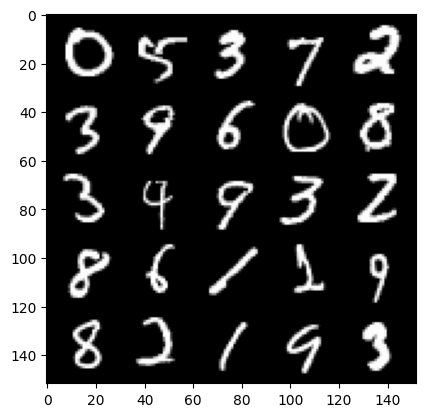

 26%|██▌       | 245/938 [00:06<00:17, 38.65it/s]

Epoch 133, step 125000: Generator loss: -0.0036256075523793687, discriminator loss: -0.3246498058408505
----------------fake images-------------


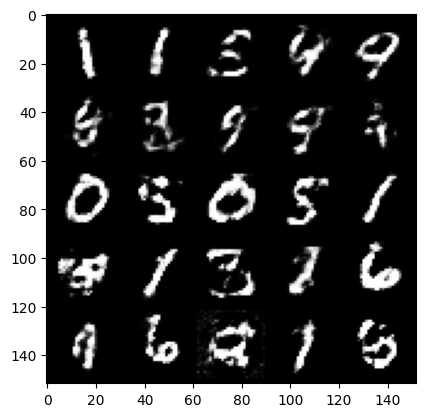

----------------real images-------------


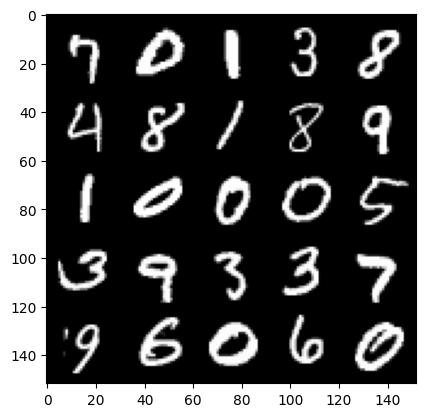

 59%|█████▉    | 556/938 [00:16<00:11, 32.42it/s]

Epoch 138, step 130000: Generator loss: -0.06009272817634046, discriminator loss: -0.3221696103431285
----------------fake images-------------


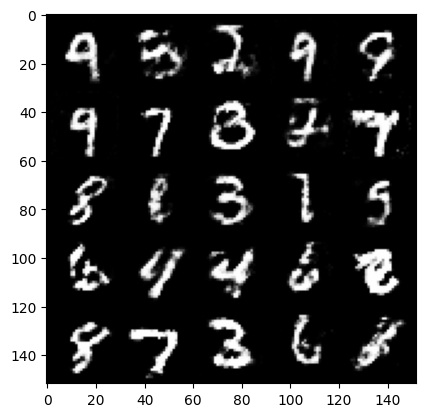

----------------real images-------------


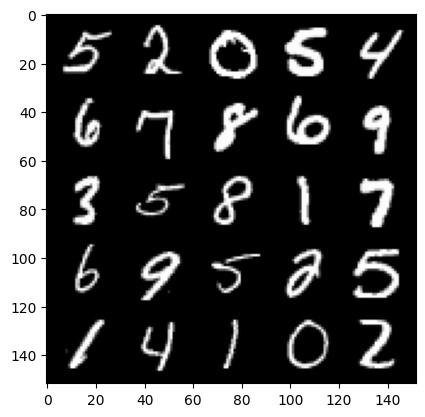

 92%|█████████▏| 866/938 [00:24<00:01, 36.45it/s]

Epoch 143, step 135000: Generator loss: -0.07347472267318496, discriminator loss: -0.30737452494203993
----------------fake images-------------


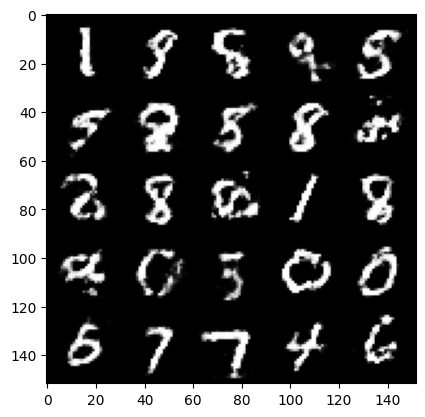

----------------real images-------------


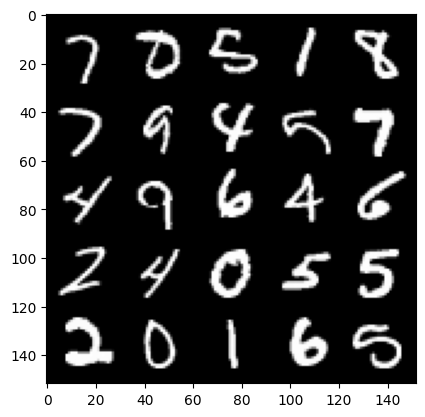

 25%|██▌       | 238/938 [00:06<00:18, 38.27it/s]

Epoch 149, step 140000: Generator loss: -0.0680099904648959, discriminator loss: -0.3132624459497622
----------------fake images-------------


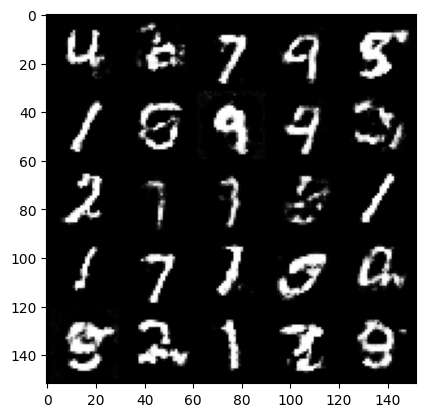

----------------real images-------------


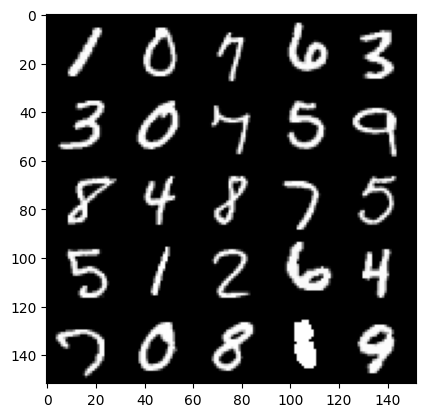

 58%|█████▊    | 548/938 [00:15<00:12, 31.87it/s]

Epoch 154, step 145000: Generator loss: -0.05196694888174524, discriminator loss: -0.29805644444078083
----------------fake images-------------


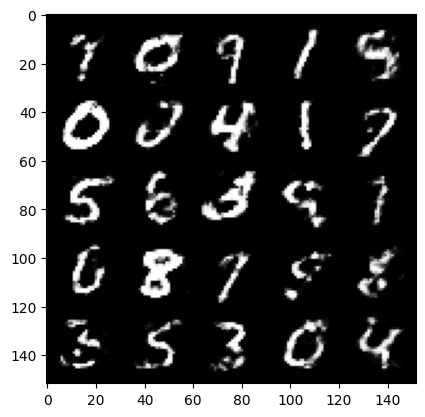

----------------real images-------------


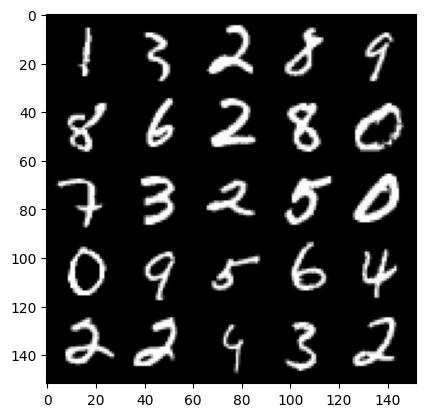

 91%|█████████▏| 858/938 [00:25<00:02, 38.38it/s]

Epoch 159, step 150000: Generator loss: -0.036668483577854884, discriminator loss: -0.28955541409775604
----------------fake images-------------


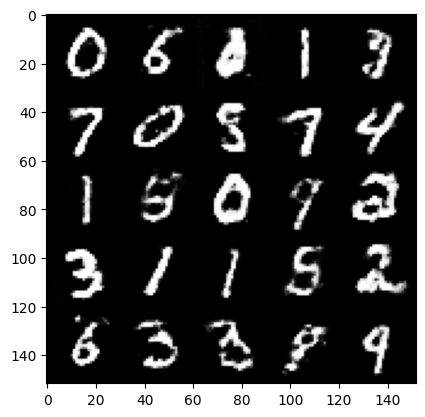

----------------real images-------------


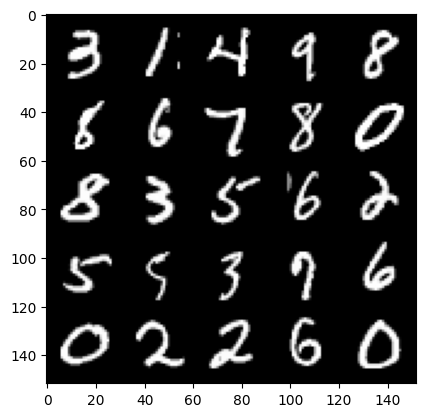

 24%|██▍       | 229/938 [00:06<00:18, 38.09it/s]

Epoch 165, step 155000: Generator loss: 0.00495972430706021, discriminator loss: -0.2900180005177861
----------------fake images-------------


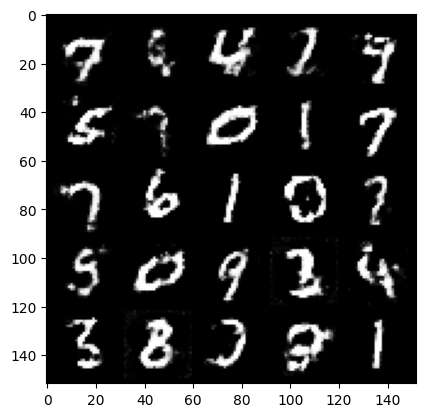

----------------real images-------------


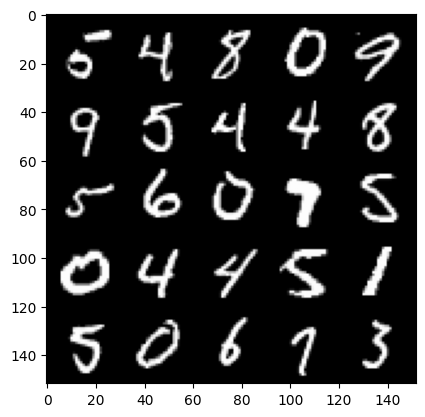

 57%|█████▋    | 537/938 [00:15<00:10, 37.33it/s]

Epoch 170, step 160000: Generator loss: 0.0035734619710594334, discriminator loss: -0.2866978566564623
----------------fake images-------------


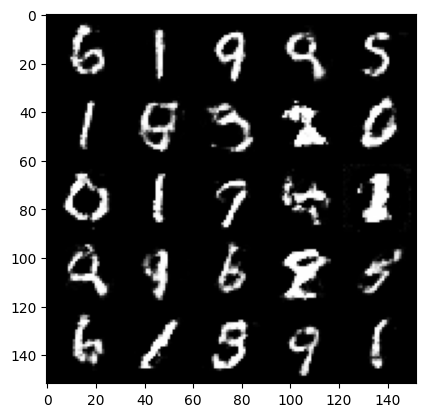

----------------real images-------------


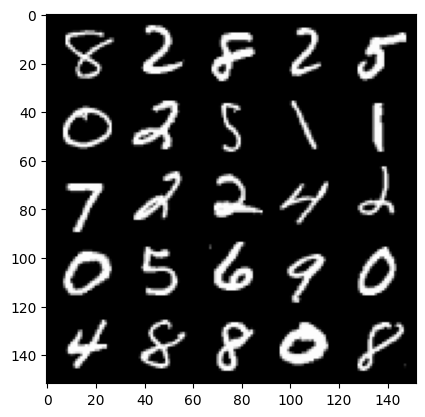

 90%|█████████ | 847/938 [00:25<00:02, 36.15it/s]

Epoch 175, step 165000: Generator loss: -0.05519946530628942, discriminator loss: -0.2762070306882263
----------------fake images-------------


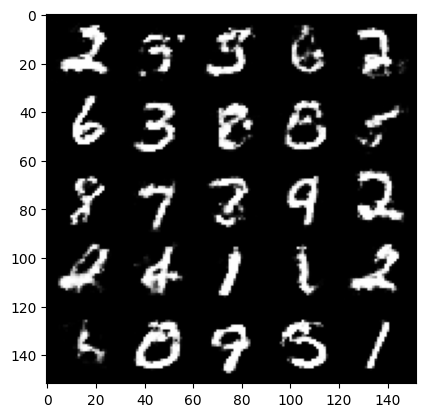

----------------real images-------------


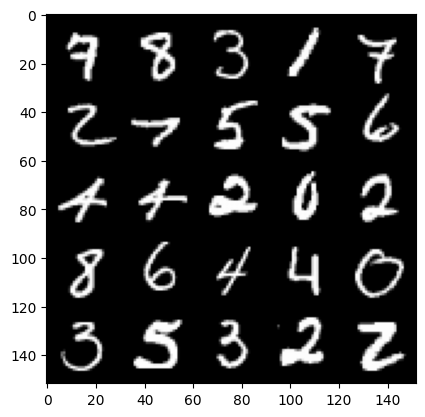

 24%|██▎       | 221/938 [00:06<00:19, 37.00it/s]

Epoch 181, step 170000: Generator loss: -0.03467871721033006, discriminator loss: -0.2743095310039814
----------------fake images-------------


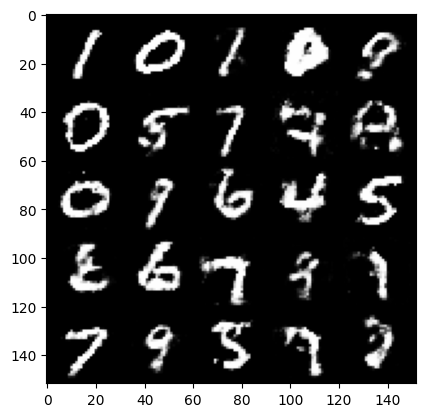

----------------real images-------------


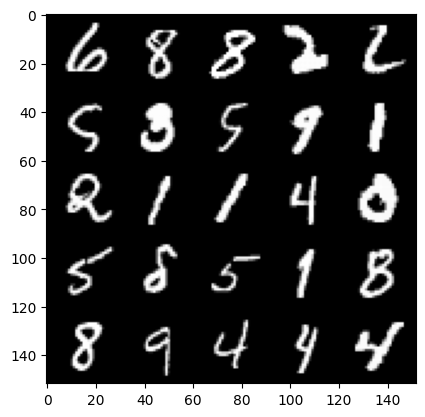

 56%|█████▋    | 529/938 [00:15<00:11, 35.67it/s]

Epoch 186, step 175000: Generator loss: -0.050302769192680605, discriminator loss: -0.263714233192429
----------------fake images-------------


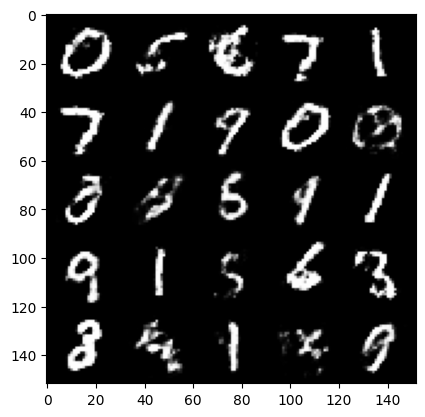

----------------real images-------------


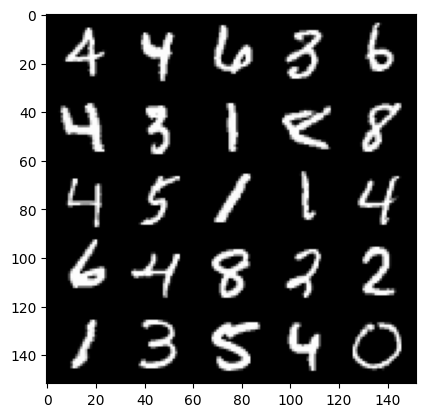

 89%|████████▉ | 839/938 [00:25<00:02, 34.72it/s]

Epoch 191, step 180000: Generator loss: -0.03953285722024742, discriminator loss: -0.26510661262087554
----------------fake images-------------


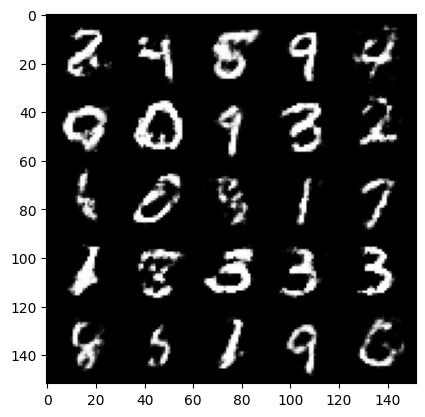

----------------real images-------------


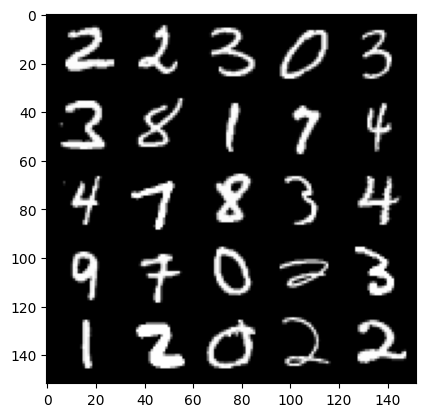

 23%|██▎       | 214/938 [00:06<00:21, 34.35it/s]

Epoch 197, step 185000: Generator loss: -0.07463601528629668, discriminator loss: -0.2536828550025824
----------------fake images-------------


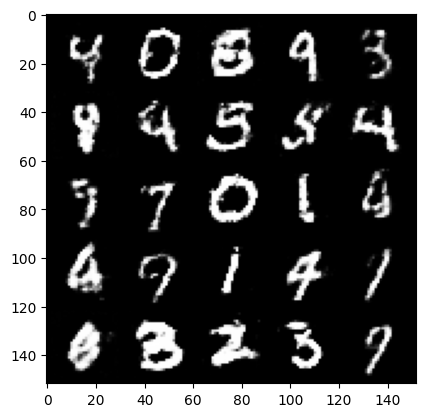

----------------real images-------------


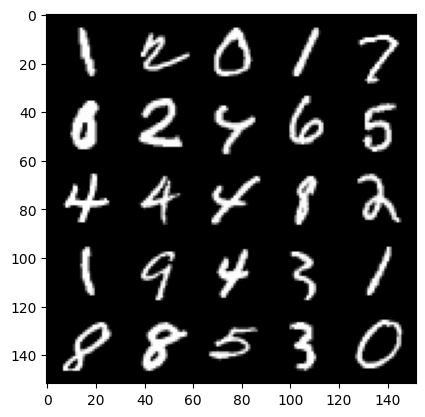

100%|██████████| 938/938 [00:28<00:00, 32.76it/s]


In [50]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for i,(imgs,labels) in enumerate(tqdm(dataloader)):
        real_imgs = imgs.to(device).requires_grad_(True)
        #-------------------
        #Train discriminator
        #-------------------
        optimizer_D.zero_grad()

        z = torch.normal(0,1,(real_imgs.size(0),latent_dim)).to(device)

        fake_imgs = generator(z)

        real_validity = discriminator(real_imgs)

        fake_validity = discriminator(fake_imgs)



        div_gp = gradient_penalty = calculate_gradient_penalty(real_imgs, fake_imgs,
                                                              real_validity, fake_validity, 2, 6)

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()


        # Keep track of the average discriminator loss
        mean_discriminator_loss += d_loss.item() / display_step


        optimizer_G.zero_grad()
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------

            #generate a batch of images
            fake_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            # Keep track of the average generator loss
            mean_generator_loss += g_loss.item() / display_step

            ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            print('----------------fake images-------------')
            show_tensor_images(fake_imgs)
            print('----------------real images-------------')
            show_tensor_images(real_imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1